# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

----

<a id='start'></a>
# Содержание



## Подготовка данных
   * <a href='#step_1'> Загружаем библиотеки </a>
   * <a href='#step_1'> Откроем файл и изучим его </a>
          - Путь к файлу: (/datasets/autos.csv)
   * <a href='#step_1.1'> Просмотим зависимотсть целевого значения от других признаков в наших данных на гарфике </a>
   * <a href='#step_1.1.1'>Применим кодирование текстовых данных в категориальные цифровые значения методом `OrdinalEncoder`</a>
   * <a href='#step_1.2'> Разделим данные на тренировочную выборку и целевой признак </a>
   * <a href='#step_1.3'> Применим масштабирование к нашим данным при помощи `StandardScaler`</a>
   * <a href='#step_1.end'> Вывод </a>

## Обучение моделей
   * <a href='#step_2.1'> Создадим функцию для подсчёта $RMSE$ </a>
   * <a href='#step_2.1'> Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков </a>
   * <a href='#step_2.1'> LinearRegression </a>
   * <a href='#step_2.2'>RandomForestRegressor</a>
   * <a href='#step_2.3'> CatBoostRegressor </a>
   * <a href='#step_2.4'> LightGBM  </a>
  
   * <a href='#step_2.end'> Вывод </a>   
   
   
## Анализ моделей
   * <a href='#step_3'>Проанализируем скорость работы и качество моделей и занесём данные в сводную таблицу </a>
   * <a href='#step_3.2'>Проведём анализ остатков предсказаний моделей и определим что и как модель чаще всего хорошо/плохо предсказывает</a>
   * <a href='#step_3.3'>Вывод</a>
   
## Общий вывод   
   * <a href='#step_3.end'> Вывод </a>
   
 <font color='orange'><u>INFO</u>:<font color='gray'> При запуске ячеек, запустить <font color='green'><i>"Restart & Run All"

-----
----

## Загружаем библиотеки


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time

<a id="step_1"></a>
## Подготовка данных

### Откроем файлы и изучим их

In [ ]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Приведём столбцы с датой к формату `datetime64`

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Посмотрим на целевой столбец *Price* с ценой автомобилей

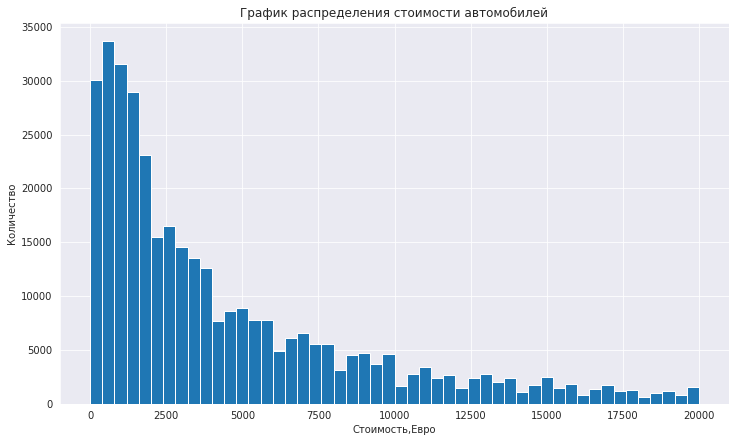

In [ ]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [ ]:
data.loc[data['Price'] < 10]['Price'].count()

12028

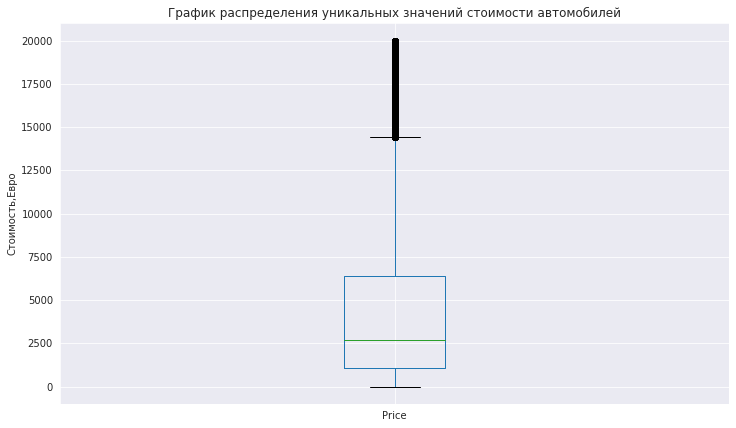

In [ ]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

##### Удалим данные стоимости автомобилей ниже *10€*, т.к. такие значения нам не интересны. Владельцы а/м могут указывать такую цену только за разбитый а/м под восставновление, либо с расчётом на равноценный обмен.

In [ ]:
data = data.query('Price> 10')

In [ ]:
data.loc[data['Price'] < 10]['Price'].count()

0

### Посмотрим на отсутствующие значения колонки "VehicleType" и заполним их значением N/A

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342257 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          342257 non-null datetime64[ns]
Price                342257 non-null int64
VehicleType          309055 non-null object
RegistrationYear     342257 non-null int64
Gearbox              325355 non-null object
Power                342257 non-null int64
Model                325026 non-null object
Kilometer            342257 non-null int64
RegistrationMonth    342257 non-null int64
FuelType             313315 non-null object
Brand                342257 non-null object
NotRepaired          277131 non-null object
DateCreated          342257 non-null datetime64[ns]
NumberOfPictures     342257 non-null int64
PostalCode           342257 non-null int64
LastSeen             342257 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 44.4+ MB


In [ ]:
data['VehicleType']=data['VehicleType'].fillna('N/A')

#### Проверим результат

In [ ]:
data.VehicleType.isna().sum()

0

### Проверим столбец "RegistrationYear" на уникальные значения

In [ ]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

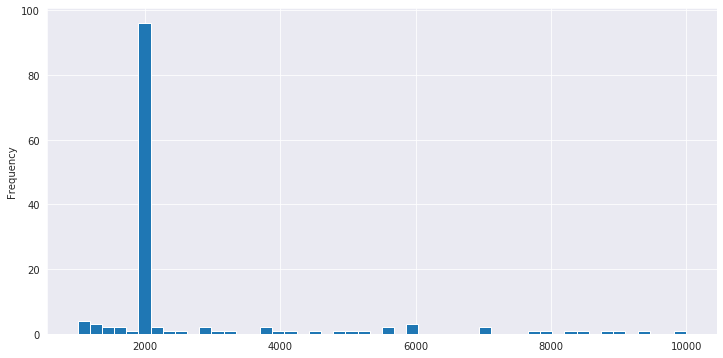

In [ ]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.show()

### Вычислим дату формирования списков а/м и отсортируем данные о регистрации по этой дате, а так же удалим совсем старые а/м, которым более 67 лет.

In [ ]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [ ]:
data=data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

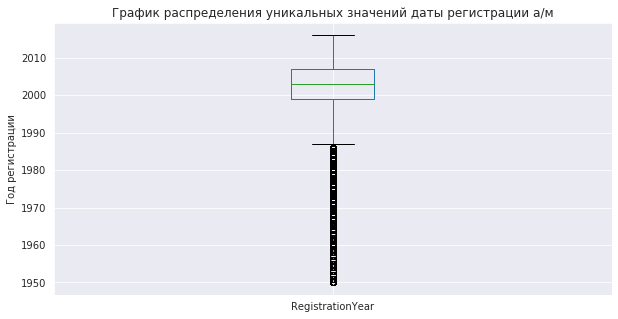

In [ ]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328385 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          328385 non-null datetime64[ns]
Price                328385 non-null int64
VehicleType          328385 non-null object
RegistrationYear     328385 non-null int64
Gearbox              313265 non-null object
Power                328385 non-null int64
Model                313070 non-null object
Kilometer            328385 non-null int64
RegistrationMonth    328385 non-null int64
FuelType             304746 non-null object
Brand                328385 non-null object
NotRepaired          269271 non-null object
DateCreated          328385 non-null datetime64[ns]
NumberOfPictures     328385 non-null int64
PostalCode           328385 non-null int64
LastSeen             328385 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 42.6+ MB


### Посмотрим на отсутствующие данные по столбцу "Gearbox"

In [ ]:
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,2016-04-01 12:46:46,300,N/A,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,N/A,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,N/A,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,N/A,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,N/A,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


##### Информация о корбкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении. В связи с этим лучше избавиться от этих данных во избежании лишнего "шума", чем заполнить пропуски каким-то значением. К тому же по данным строкам есть множество ошибочных значений и пропусков в других столбцах

In [ ]:
data.dropna(subset=['Gearbox'], inplace=True)

##### Проверим результат

In [ ]:
data.Gearbox.unique()

array(['manual', 'auto'], dtype=object)

### Посмотрим на значения в столбце "Power"

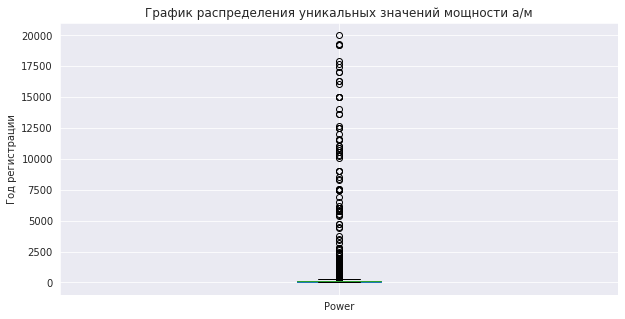

In [ ]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

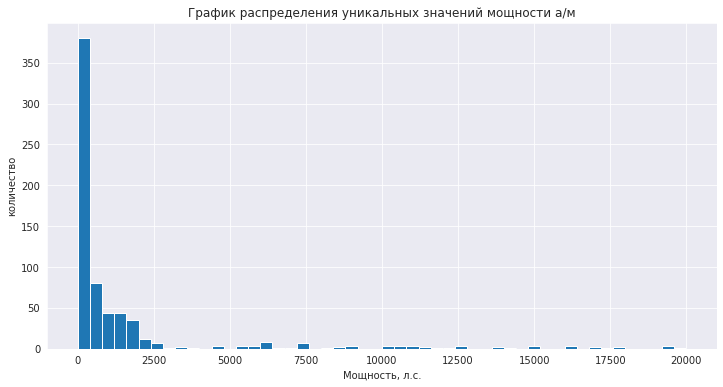

In [ ]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

##### Очевидно, что таких мощностей не бывает и такие данные так же требуется удалить из  нашей базы данных.

In [ ]:
data.Power.describe()

count    313265.000000
mean        115.633425
std         184.833026
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

#####  Удалим данные о мощности дигателя свыше 2500 л.с. и менее 15 л.с.

In [ ]:
data=data.query('Power > 15 & Power < 2500')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290446 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          290446 non-null datetime64[ns]
Price                290446 non-null int64
VehicleType          290446 non-null object
RegistrationYear     290446 non-null int64
Gearbox              290446 non-null object
Power                290446 non-null int64
Model                280162 non-null object
Kilometer            290446 non-null int64
RegistrationMonth    290446 non-null int64
FuelType             276254 non-null object
Brand                290446 non-null object
NotRepaired          250140 non-null object
DateCreated          290446 non-null datetime64[ns]
NumberOfPictures     290446 non-null int64
PostalCode           290446 non-null int64
LastSeen             290446 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 37.7+ MB


### Просмотрим пропущенные значения по столбцу "Model"

In [ ]:
data.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25


##### Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из наших данных

In [ ]:
data.dropna(subset=['Model'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          280162 non-null datetime64[ns]
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             268296 non-null object
Brand                280162 non-null object
NotRepaired          243099 non-null object
DateCreated          280162 non-null datetime64[ns]
NumberOfPictures     280162 non-null int64
PostalCode           280162 non-null int64
LastSeen             280162 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 36.3+ MB


###  Посмотрим на данные о пробеге а/м в столбце "Kilometer"

In [ ]:
data.Kilometer.describe()

count    280162.000000
mean     128324.201712
std       36542.700155
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

##### Данный столбец не требует изменений, здесь всё Ок.

###  Посмотрим на значения в столбце "RegistrationMonth"

In [ ]:
data.RegistrationMonth.describe()

count    280162.000000
mean          6.054511
std           3.554271
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [ ]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9])

In [ ]:
data.RegistrationMonth.value_counts()

3     29193
6     26222
4     24561
5     24409
7     22669
10    21986
12    20258
11    20214
9     20128
1     19253
8     18831
2     17999
0     14439
Name: RegistrationMonth, dtype: int64

##### Т.к. этот параметр не имеет особого значения на ценообразование, а терять данные нам не хочется, заменим нулевые значения на среднее значение

In [ ]:
data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] =6

##### Проверяем результат

In [ ]:
data.loc[data['RegistrationMonth'] == 6].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
18,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11
31,2016-03-29 16:57:02,899,N/A,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,6,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09


In [ ]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9])

### Посмотроим на значения в столбце "FuelType"

In [ ]:
data.FuelType.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
data.FuelType.value_counts()

petrol      178272
gasoline     84917
lpg           4359
cng            462
hybrid         178
other           70
electric        38
Name: FuelType, dtype: int64

In [ ]:
data.FuelType.isna().sum()

11866

##### Заполним отсутствующие значения как "other"

In [ ]:
data['FuelType']=data['FuelType'].fillna('other')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          280162 non-null datetime64[ns]
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             280162 non-null object
Brand                280162 non-null object
NotRepaired          243099 non-null object
DateCreated          280162 non-null datetime64[ns]
NumberOfPictures     280162 non-null int64
PostalCode           280162 non-null int64
LastSeen             280162 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 36.3+ MB


In [ ]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

##### Отлично, здесь ничего дополнять или удалять не требуется

### Посмотрим на значения  в столбце "NotRepaired"     

In [ ]:
data.NotRepaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [ ]:
data.NotRepaired.isna().sum()

37063

##### Очевидно, что эти данные лучше заполнить N/A, чем потерять 39000 строк остального массива данных

In [ ]:
data['NotRepaired']=data['NotRepaired'].fillna('N/A')

##### Проверяем

In [ ]:
data.NotRepaired.unique()

array(['N/A', 'no', 'yes'], dtype=object)

### Посмотрим на значения  в столбце "DateCreated"     

In [ ]:
data.DateCreated.describe()

count                  280162
unique                    105
top       2016-04-03 00:00:00
freq                    11058
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

### Посмотрим на значения  в столбце "NumberOfPictures"          

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          280162 non-null datetime64[ns]
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             280162 non-null object
Brand                280162 non-null object
NotRepaired          280162 non-null object
DateCreated          280162 non-null datetime64[ns]
NumberOfPictures     280162 non-null int64
PostalCode           280162 non-null int64
LastSeen             280162 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 36.3+ MB


In [ ]:
data.NumberOfPictures.describe()

count    280162.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

##### В данном столбце нет никакой пользы для обучения модели, т.к. кроме нулей здесь значений нет. Такой столбец лучше так же исключить из списка 

In [ ]:
data=data.drop(['NumberOfPictures'], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 15 columns):
DateCrawled          280162 non-null datetime64[ns]
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             280162 non-null object
Brand                280162 non-null object
NotRepaired          280162 non-null object
DateCreated          280162 non-null datetime64[ns]
PostalCode           280162 non-null int64
LastSeen             280162 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 34.2+ MB


### Посмотрим на значения  в столбце "PostalCode"

In [ ]:
data.PostalCode.describe()

count    280162.000000
mean      51336.703914
std       25778.480432
min        1067.000000
25%       30982.000000
50%       50374.000000
75%       72172.000000
max       99998.000000
Name: PostalCode, dtype: float64

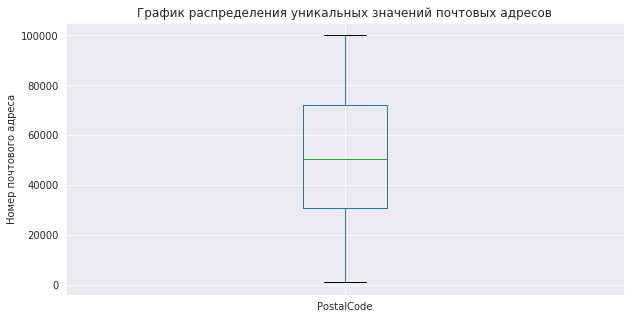

In [ ]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

##### Распределение почтовых номеров говорит нам о том, что здесь нет необходимости что-либо корректировать, а  сохранять такие данные следует только с целью вычисления географической принадлежности а/м. В нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру

In [ ]:
data["PostalCode"]=data["PostalCode"].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 15 columns):
DateCrawled          280162 non-null datetime64[ns]
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             280162 non-null object
Brand                280162 non-null object
NotRepaired          280162 non-null object
DateCreated          280162 non-null datetime64[ns]
PostalCode           280162 non-null object
LastSeen             280162 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(7)
memory usage: 34.2+ MB


In [ ]:
first_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_index.append(case_word)
data["GeogrphyIndex"]=first_index
data["GeogrphyIndex"]=data["GeogrphyIndex"].astype('int')


##### Провермим результат

In [ ]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9


### Посмотрим на значения  в столбце "LastSeen"

In [ ]:
data.LastSeen.describe()

count                  280162
unique                 147489
top       2016-04-06 01:15:23
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

### Посмотрим коррелирущие значения  после предобработки данных

In [ ]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,GeogrphyIndex
Price,1,0.517905,0.423791,-0.396117,0.0148122,0.0578395
RegistrationYear,0.517905,1,0.116959,-0.326067,0.00358219,0.0225388
Power,0.423791,0.116959,1,0.0874046,0.018411,0.0391257
Kilometer,-0.396117,-0.326067,0.0874046,1,0.00366006,-0.0161264
RegistrationMonth,0.0148122,0.00358219,0.018411,0.00366006,1,-0.00730795
GeogrphyIndex,0.0578395,0.0225388,0.0391257,-0.0161264,-0.00730795,1


##### Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации а/м, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля

<a id="step_1.1"></a>
### Просмотим зависимотсть целевого значения от других признаков в наших данных на гарфике

In [ ]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen',
       'GeogrphyIndex'],
      dtype='object')

In [ ]:
column=['Price', 'RegistrationYear',
       'Power', 'Kilometer','FuelType']

In [ ]:
data_graph=data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
2,9800,2004,163,125000,gasoline
3,1500,2001,75,150000,petrol
4,3600,2008,69,90000,gasoline
5,650,1995,102,150000,petrol
6,2200,2004,109,150000,petrol


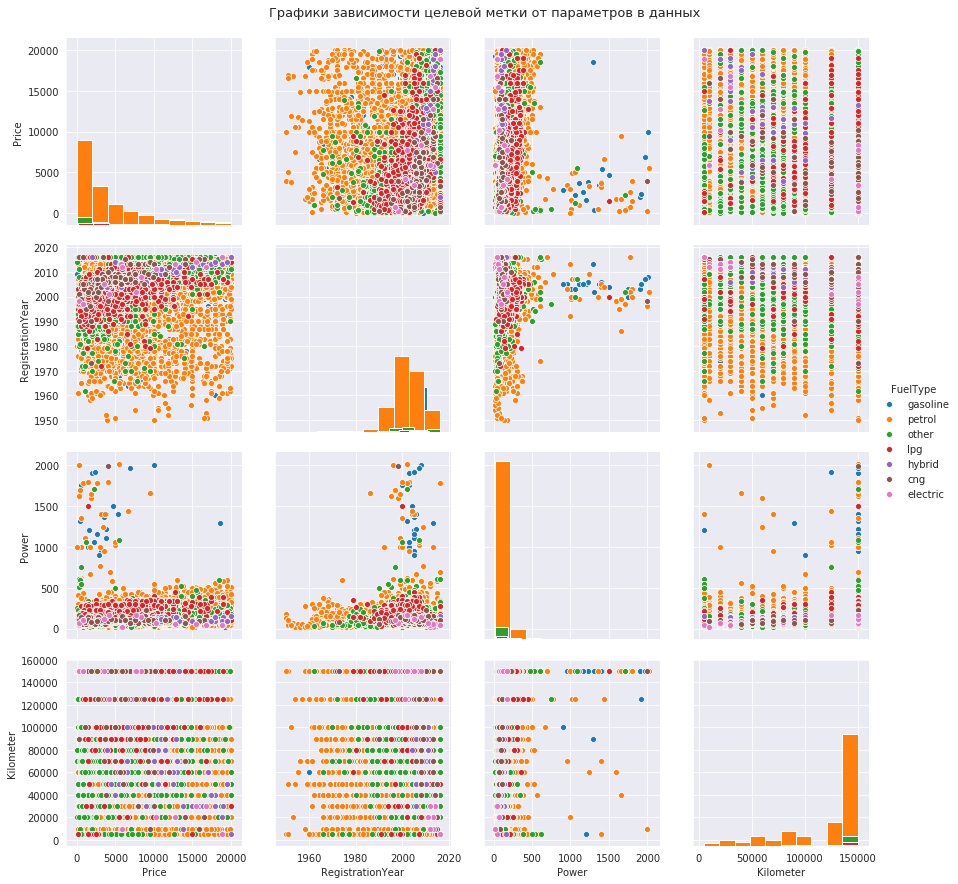

In [ ]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=3, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=13)
plt.show()

##### Судя  по графику можно сказать, что начиная с 1980 года стоимосоть а/м увеличивается с каждым годом и имеет линейную зависимость, при этом не важен тип используемого топлива. Так же из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план

<a id="step_1.1.1"></a>
## Применим кодирование текстовых данных в категориальные цифровые значения методом `OrdinalEncoder`

##### Для начала выберем действительно значимые столбцы, которые могут иметьзначения в  ценообразовании стоимости подержанных автомоблилей, а лишние значения мы опустим, чтобы не "зашумлять" вычисления моделей

In [ ]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9


In [ ]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen',
       'GeogrphyIndex'],
      dtype='object')

In [ ]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired','GeogrphyIndex']

##### Запишем данные с интересующими нас столбцами в новый Data Frame

In [ ]:
data_for_model = data[columns].copy()
data_for_model.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9


In [ ]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280162 entries, 2 to 354368
Data columns (total 12 columns):
Price                280162 non-null int64
VehicleType          280162 non-null object
RegistrationYear     280162 non-null int64
Gearbox              280162 non-null object
Power                280162 non-null int64
Model                280162 non-null object
Kilometer            280162 non-null int64
RegistrationMonth    280162 non-null int64
FuelType             280162 non-null object
Brand                280162 non-null object
NotRepaired          280162 non-null object
GeogrphyIndex        280162 non-null int64
dtypes: int64(6), object(6)
memory usage: 27.8+ MB


##### Сбросим индексы, после удаления лишних значений

In [ ]:
data_for_model=data_for_model.reset_index(drop=True)

In [ ]:
data_for_model

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,6
...,...,...,...,...,...,...,...,...,...,...,...,...
280157,5250,N/A,2016,auto,150,159,150000,12,other,alfa_romeo,no,5
280158,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,9
280159,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2
280160,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,8


<a id="step_1.2"></a>
## Разделим данные на основную выборку и целевые признаки

In [ ]:
features=data_for_model.drop(['Price'],axis=1)
target=data_for_model['Price']

In [ ]:
features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'GeogrphyIndex'],
      dtype='object')

In [ ]:
features.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex
0,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9


##### Выберем только категориальные признаки

In [ ]:
col=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'NotRepaired']

In [ ]:
encoder = OrdinalEncoder()
encoder.fit(features[col])
features_ord=features.copy()
features_ord[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

##### Проверим результат

In [ ]:
features_ord.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex
0,7.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0.0,9
1,6.0,2001,1.0,75,116.0,150000,6,6.0,37.0,1.0,9
2,6.0,2008,1.0,69,101.0,90000,7,2.0,31.0,1.0,6
3,5.0,1995,1.0,102,11.0,150000,10,6.0,2.0,2.0,3
4,2.0,2004,1.0,109,8.0,150000,8,6.0,25.0,1.0,6


### Определим тестовую и тренировочну выбрку

In [ ]:
train_features, test_features, train_target, test_target = train_test_split(features_ord,target, test_size=0.25, random_state=254)

### Проверим результат

In [ ]:
train_sample=train_features.shape[0]/features.shape[0]
test_sample=test_target.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


<a id="step_1.3"></a>
## Применим масштабирование к нашим данным при помощи `StandardScaler`

In [ ]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','NotRepaired']
scaler=StandardScaler()
scaler.fit(features_ord[numeric])


train_features[numeric]=scaler.transform(train_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])


print(train_features.shape)
print(test_features.shape)

train_features.head()

(210121, 11)
(70041, 11)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex
131157,1.270064,-0.784680,0.502779,-0.188164,0.822050,0.593165,7,-1.478905,0.356673,0.076945,4
71215,1.270064,0.643525,0.502779,0.064598,-0.902373,0.593165,2,-1.478905,1.121683,0.076945,1
117181,0.389395,1.595661,-1.988945,-0.598903,-0.026027,-2.690671,6,0.710929,0.892180,0.076945,4
214534,0.829730,0.484835,-1.988945,1.786541,1.868013,0.593165,12,0.163470,-1.402852,0.076945,3
18385,0.389395,1.754351,0.502779,-0.993844,1.924551,-3.237977,9,0.710929,1.121683,0.076945,2


<a id="step_1.end"></a>
## Вывод

Отлично, из даных убраны лишние и "битые" значения, текстовые признаки трансформированы в цифровой формат, а так же выборки  разделены на тренировочную и тестовую для проверки качества предсказания моделей. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

---

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_2"></a>
## Обучение моделей

<font ><b> Обучим разные модели. Для каждой укажем оптимальные гиперпараметры и поставим счётчик времени выполнения операций.


### Для расчёта целевой метрики используем RMSE и напишем функцию.

In [ ]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

### Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков 

In [ ]:
def illustration_target(test,predict):
    rmse= mean_squared_error(test,predict)
    mae=mean_absolute_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    #plt.text(25222,11225,'MAE={:.2f}'.format(mae))
    #plt.text(25222,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

### Для понимания, какие факторы важны при моделировании, создадим функцию, используя <br><br>`feature_importances_ `

In [ ]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

<a id="step_2.1"></a>
### LinearRegression

In [ ]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 169 ms, sys: 94.4 ms, total: 264 ms
Wall time: 183 ms


In [ ]:
%%time
start = time.time()
predict_lr=model_lr.predict(test_features)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 12.2 ms, sys: 377 µs, total: 12.6 ms
Wall time: 7.53 ms


In [ ]:
print(' Гиперпараметры модели:\n',model_lr)

 Гиперпараметры модели:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [ ]:
mae_lr=mean_absolute_error(test_target, predict_lr)
print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
rmse_lr=rmse(test_target, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 2173.2
RMSE модели Линейная Регрессия равна: 3167.12


#### Показатели предсказания модели `LinearRegression`

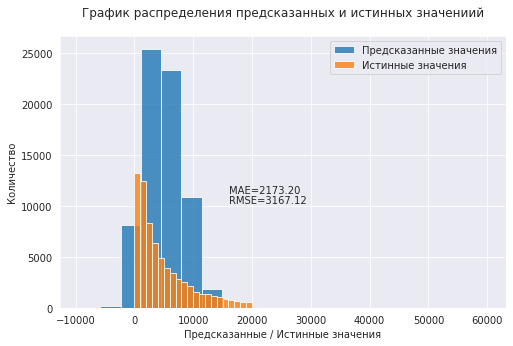

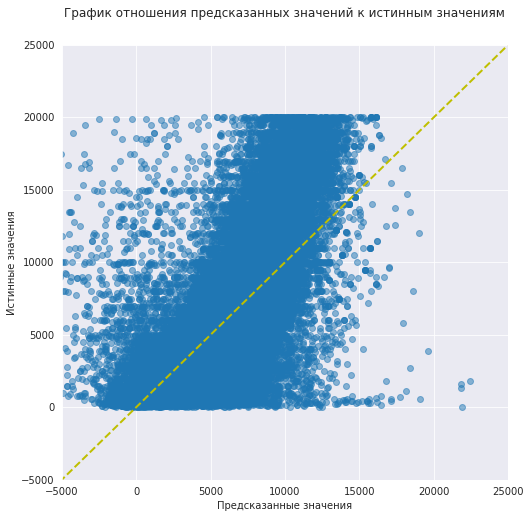

In [ ]:
illustration_target(test_target, predict_lr)

#### Факторы важности модели `LinearRegression` 

##### К сожалению для модели `LinearRegression` Факторы важности отсутствуют, т.к. модель проста и не располагает ветвлением деревьев

<a id="step_2.2"></a>
### RandomForestRegressor

In [ ]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(train_features, train_target)
end = time.time()
t_rf=round(end-start,2)

CPU times: user 1min 35s, sys: 1.26 s, total: 1min 37s
Wall time: 1min 38s


In [ ]:
print(' Гиперпараметры модели:\n',model_rf)

 Гиперпараметры модели:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)


In [ ]:
%%time
start = time.time()
pred_rf=model_rf.predict(test_features)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 3.92 s, sys: 0 ns, total: 3.92 s
Wall time: 3.93 s


#### Показатели предсказания модели `RandomForestRegressor`

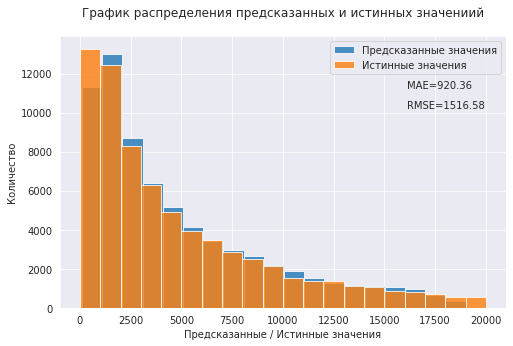

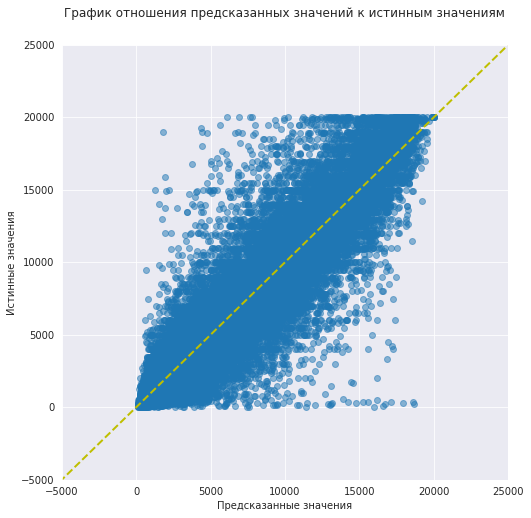

In [ ]:
rmse_rf = rmse(test_target,pred_rf)
mae_rf=mean_absolute_error(test_target, pred_rf)
illustration_target(test_target, pred_rf)

#### Факторы важности модели `RandomForestRegressor`

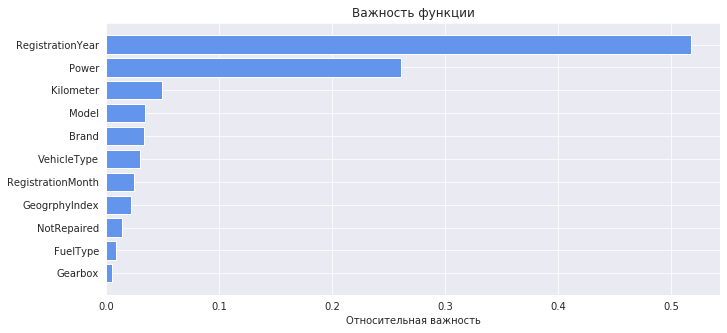

,Относительная важность
RegistrationYear,0.517400
Power,0.261159
Kilometer,0.049582
Model,0.034100
Brand,0.033255
VehicleType,0.030224
RegistrationMonth,0.024582
GeogrphyIndex,0.022135
NotRepaired,0.013846
FuelType,0.008282


In [ ]:
importances(model_rf,test_features)

<a id="step_2.3"></a>
### CatBoostRegressor

In [ ]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=123,learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat.fit(train_features, train_target, eval_set=(test_features,test_target))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 3500.8054472	test: 3490.6197555	best: 3490.6197555 (0)	total: 247ms	remaining: 4m 7s
100:	learn: 1597.9324668	test: 1621.8558908	best: 1621.8558908 (100)	total: 16.2s	remaining: 2m 23s
200:	learn: 1520.1831282	test: 1574.6176463	best: 1574.6176463 (200)	total: 32.8s	remaining: 2m 10s
300:	learn: 1471.1541721	test: 1549.7260183	best: 1549.6982976 (299)	total: 48.8s	remaining: 1m 53s
400:	learn: 1434.7594355	test: 1536.8225743	best: 1536.8225743 (400)	total: 1m 4s	remaining: 1m 36s
500:	learn: 1407.7501003	test: 1529.5944506	best: 1529.5225070 (499)	total: 1m 20s	remaining: 1m 20s
600:	learn: 1385.7603352	test: 1523.6189787	best: 1523.5047259 (599)	total: 1m 36s	remaining: 1m 4s
700:	learn: 1365.5769096	test: 1517.6260128	best: 1517.6260128 (700)	total: 1m 52s	remaining: 48.1s
800:	learn: 1347.4470934	test: 1512.3326509	best: 1512.3326509 (800)	total: 2m 8s	remaining: 31.9s
900:	learn: 1331.4599017	test: 1509.7065069	best: 1509.3994545 (896)	total: 2m 24s	remaining: 15.9s
999:	

In [ ]:
%%time
start = time.time()
predict_cat=model_cat.predict(test_features)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 161 ms, sys: 7.57 ms, total: 169 ms
Wall time: 110 ms


#### Показатели предсказания модели `CatBoostRegressor`

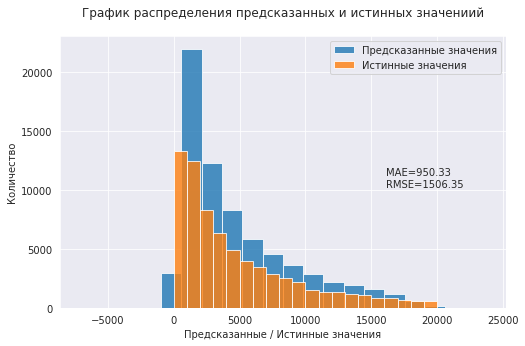

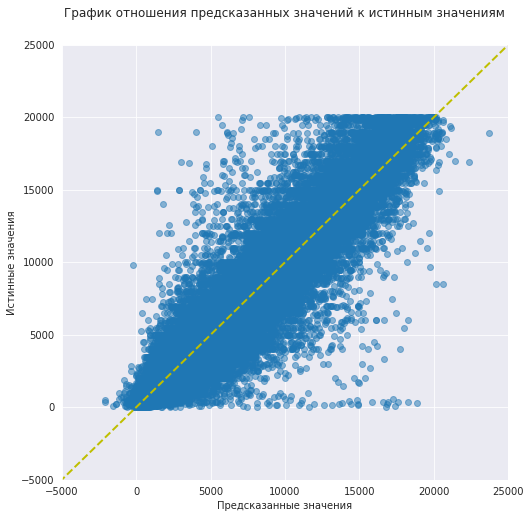

In [ ]:
rmse_cat=rmse(test_target, predict_cat)
mae_cat=mean_absolute_error(test_target, predict_cat).round(2)
illustration_target(test_target, predict_cat)

#### Факторы важности модели `CatBoostRegressor`

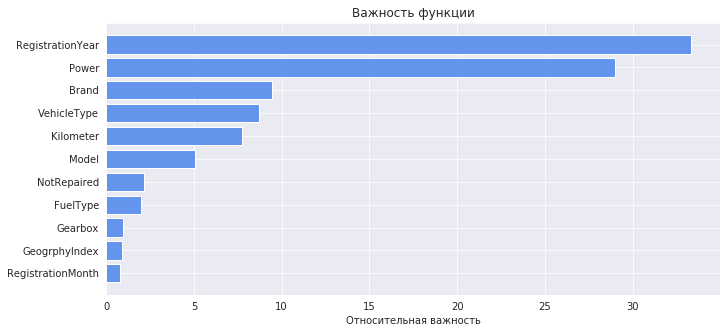

,Относительная важность
RegistrationYear,33.312101
Power,28.998909
Brand,9.448986
VehicleType,8.707104
Kilometer,7.717266
Model,5.047709
NotRepaired,2.156141
FuelType,1.971700
Gearbox,0.943006
GeogrphyIndex,0.907475


In [ ]:
importances(model_cat,train_features)

<a id="step_2.4"></a>
### LightGBM

In [ ]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=123, learning_rate=0.4, objective='rmse')
model_LGB.fit(train_features, train_target, eval_set=(test_features,test_target), verbose=100)
end = time.time()
t_lgb=round(end-start,2)

[100]	valid_0's rmse: 1569.09
[200]	valid_0's rmse: 1535.7
[300]	valid_0's rmse: 1522.74
[400]	valid_0's rmse: 1515.32
[500]	valid_0's rmse: 1512.62
[600]	valid_0's rmse: 1509.59
[700]	valid_0's rmse: 1507.2
[800]	valid_0's rmse: 1507.01
[900]	valid_0's rmse: 1505.53
[1000]	valid_0's rmse: 1505.11
CPU times: user 49.8 s, sys: 156 ms, total: 49.9 s
Wall time: 50.7 s


In [ ]:
%%time
start = time.time()
predict_LGB= model_LGB.predict(test_features)
end = time.time()
t_lgb_p=round(end-start,2)

CPU times: user 6.87 s, sys: 0 ns, total: 6.87 s
Wall time: 6.9 s


In [ ]:
print(' Гиперпараметры модели:\n',model_LGB)

 Гиперпараметры модели:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective='rmse',
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


#### Показатели предсказания модели `LightGBM`

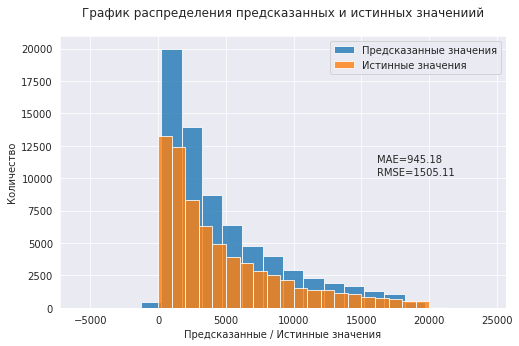

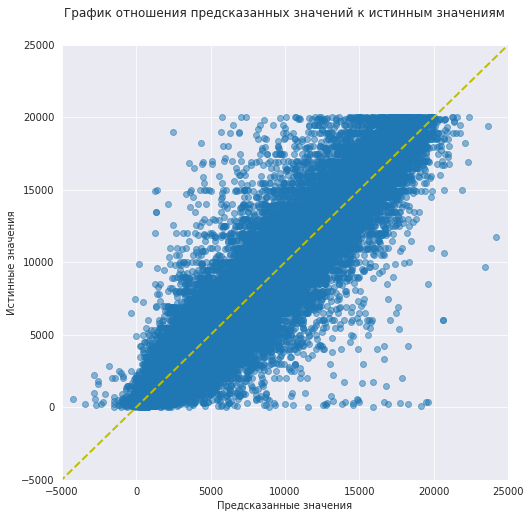

In [ ]:
rmse_gbm=rmse(test_target, predict_LGB)
mae_gbm=mean_absolute_error(test_target, predict_LGB).round(2)
illustration_target(test_target, predict_LGB)

#### Факторы важности модели `LightGBM`

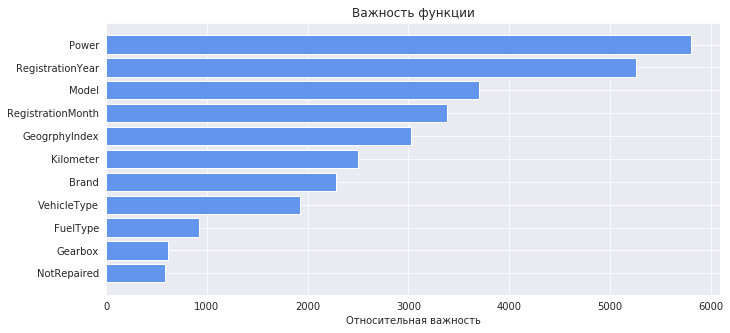

,Относительная важность
Power,5804
RegistrationYear,5261
Model,3705
RegistrationMonth,3383
GeogrphyIndex,3027
Kilometer,2502
Brand,2277
VehicleType,1925
FuelType,920
Gearbox,612


In [ ]:
importances(model_LGB,train_features)

<a id="step_2.end"></a>
## Вывод

По качеству предсказания на метрике $MAE$ и распределению значений на графиках лучше всех себя показала модель `RandomForestRegressor`, в то время как модель `LightGBM` показала лучший результат по $RMSE$ и в отличии от двух других моделей важность года регистрации (*RegistrationYear*) ушла на второй план уступив мощности (*Power*), а вот модель `LinearRegression` оказаласть совсем не точной, но за то быстрее всех.

----

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3"></a>
## Анализ моделей

### Проанализируем скорость работы и качество моделей.

<b>Для наглядности сведём все интересующие нас даные в таблицу

In [ ]:
column=['RMSE модели','MAE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели','MAE модели','Скорость обучения, s', 'Скорость предсказания, s'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr, mae_lr, t_lr, t_lr_p
comparison_tabl['RandomForestRegressor'] = rmse_rf, mae_rf, t_rf, t_rf_p
comparison_tabl['CatBoostRegressor'] = rmse_cat,mae_cat, t_cat, t_cat_p
comparison_tabl['LightGBM'] = rmse_gbm,mae_gbm,t_lgb,t_lgb_p

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)


,RMSE модели,MAE модели,"Скорость обучения, s","Скорость предсказания, s"
LinearRegression,3167.12,2173.2,0.18,0.01
RandomForestRegressor,1516.58,920.363,98.05,3.93
CatBoostRegressor,1506.35,950.33,164.64,0.11
LightGBM,1505.11,945.18,50.71,6.9


<a id="step_3.2"></a>
### Проведём анализ остатков предсказаний моделей и определим что и как модель чаще всего хорошо/плохо предсказывает

#### Добавим в выборку категоризацию по типу возрастного класса а/м

In [ ]:
features1=features.copy()

#####  Для дальнейшей фильтрации, посмотрим список присутствующих значений в нашей выборке по годам в порядке возростания

In [ ]:
pd.Series(features1['RegistrationYear'].unique()).sort_values(ascending=True)

64    1950
62    1951
63    1952
56    1953
57    1954
      ... 
20    2012
24    2013
4     2014
28    2015
15    2016
Length: 67, dtype: int64

#### Добавим категории в нашу выборку в зависимсоти от года авто `ретро, суперретро, старая, новая`

In [ ]:
k=[]
for i in features1['RegistrationYear']:
    if i <= 1980:
        s_old='Super Retro'
        k.append(s_old)
    if i > 1980 and i <= 2000:
        retro='Retro'
        k.append(retro)
    if i > 2000 and i <= 2012:
        old='Old'
        k.append(old)
    if i > 2012:
        new='New'
        k.append(new)
features['AgeType']=k

##### Проверяем результат

In [ ]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex,AgeType
0,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9,Old
1,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9,Old
2,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6,Old
3,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3,Retro
4,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,6,Old


#### Добавим разницу значений `предсказания` - `истинные значения` в таблицу для наших моделей

In [ ]:
test_features['AgeType']=features['AgeType'][test_features.index]

In [ ]:
test_features['Test_LGBM']=predict_LGB-test_target
test_features['Test_CAT']=predict_cat-test_target
test_features['Test_RandomForest']=pred_rf-test_target
test_features['Test_LinRegressor']=predict_lr-test_target
test_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,GeogrphyIndex,AgeType,Test_LGBM,Test_CAT,Test_RandomForest,Test_LinRegressor
192985,1.270064,-0.308612,0.502779,-0.093378,0.878589,0.593165,2,0.710929,1.274686,0.076945,9,Old,-41.796908,-102.254871,459.630000,47.468263
36440,-0.050939,0.484835,0.502779,-0.267152,-0.930643,0.593165,5,0.710929,0.280172,0.076945,3,Old,914.145862,697.065497,577.900000,59.808420
2119,0.389395,-0.308612,0.502779,-0.741082,1.670128,0.593165,8,0.710929,0.509675,-2.023728,8,Old,43.438132,143.836524,110.796667,1259.253280
277156,-0.931608,0.008767,0.502779,1.723350,1.161281,-1.048753,12,0.710929,-0.102334,0.076945,8,Old,2308.745348,2160.560257,1900.790000,4538.174658
112911,0.829730,0.167456,-1.988945,1.517981,1.868013,0.593165,11,-1.478905,-1.402852,0.076945,3,Old,-1157.612532,-1413.897643,-1029.830000,-2773.521492


#### Составим сводную таблицу по среднему значению отклонения предсказанных от истинных значений с разбивкой на типы возраста а/м

In [ ]:
analis_table=test_features.groupby('AgeType')[['Test_LGBM','Test_CAT','Test_RandomForest','Test_LinRegressor']].mean()
analis_table.columns=['LightGBM', 'CatBoostRegressor','RandomForestRegressor','LinearRegressor']
analis_table

,LightGBM,CatBoostRegressor,RandomForestRegressor,LinearRegressor
AgeType,,,,
New,15.545357,18.011853,78.390494,792.140781
Old,-12.538149,-14.567272,9.414902,-176.858440
Retro,-0.066816,-2.475315,49.239916,416.108871
Super Retro,198.891236,195.131447,188.851963,-8831.174407


<a id="step_3.g"></a>
#### Для наглядности отобразим отклонения на графике

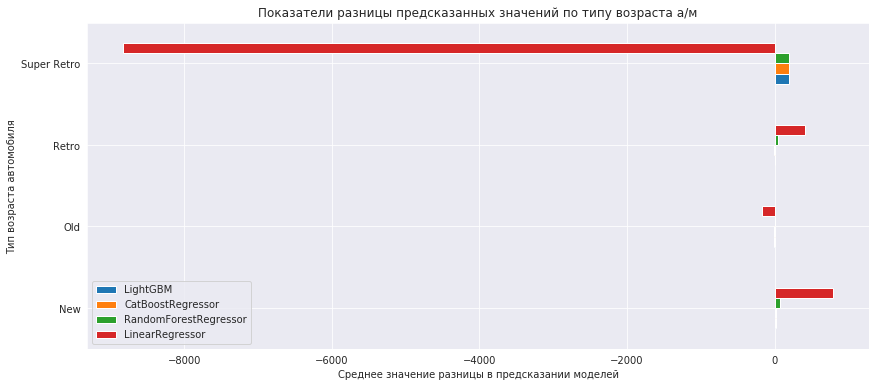

In [ ]:
analis_table.plot(kind='barh',align='center',figsize=(14,6))
plt.title('Показатели разницы предсказанных значений по типу возраста а/м')
plt.xlabel('Среднее значение разницы в предсказании моделей')
plt.ylabel('Тип возраста автомобиля')
plt.show()

<a id="step_3.3"></a>
### Вывод

По результату анализа остатков предсказания моделей, на графике хорошо видно сильное отрицательное отклонение в предсказании данных при помощи `LinearRegressor` в возростной группе автомобилей **SuperRetro**. По другим моделям наблюдается некоторый паритет по обработке возрастных категорий. Тем не менее в группе **SuperRetro**, модели использующие градиентный спуск так же чаще ошибаются в предсказаниях.

---

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3.end"></a>
## Общий вывод

   Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.<br>
   
   Мы использовали технологию градиетного бустинга в моделях `CatBoostRegressor` и `LightGBM`, и сравнили её с базовыми моделями `LinearRegression` и `RandomForestRegressor`<br>
   
   По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от `CatBoostRegressor` побеждает модель `LightGBM`, но сильно уступает по скорости предсказания.<br> 
   
   Таким образом для компании "**Не бит, не крашен**" можем смело рекомендовать модель **`CatBoostRegressor`**, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания<br> 

----